Selected File: C:/Users/Ding-Yang/Desktop/Thesis code/Preprocessing/images/20220805 necroptosis Paula_PS-A2-58 series 16/20220805 necroptosis Paula_PS-A2-58.lif
Sum of series: 49


Please enter the serie number that you're interested in::  39


The number of the image that you selected is at section 26 when the m =  2 when the z =  53
Sum of channels: 3


Please enter the channel number that you're interested in::  2


shape: (1024, 1024)
dtype: uint8
range: (0, 168)


Processing Z Values: 100%|██████████| 53/53 [00:26<00:00,  2.02z/s]


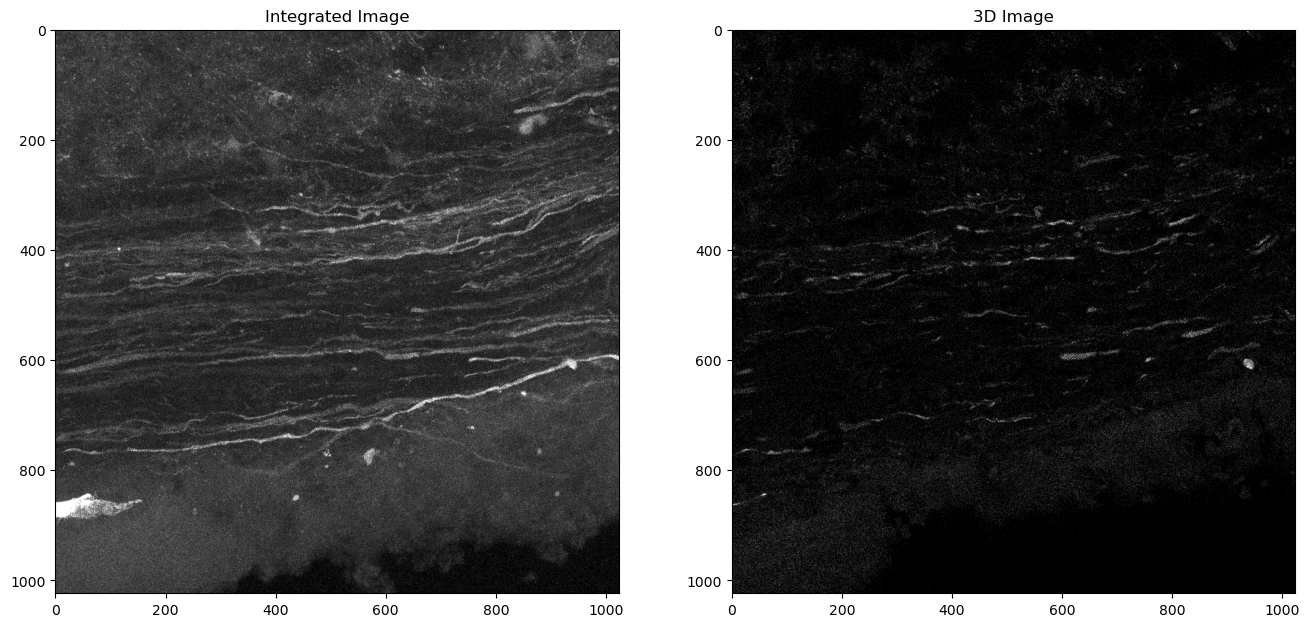

Do you want to crop the image? (y/n):  y


Script executed successfully.


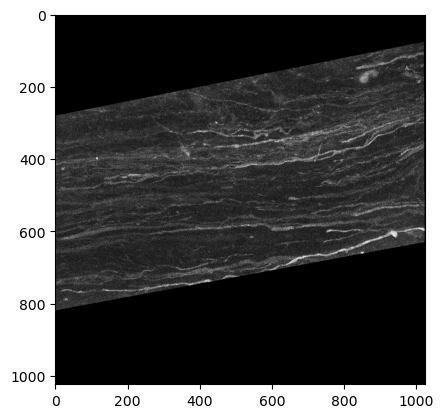

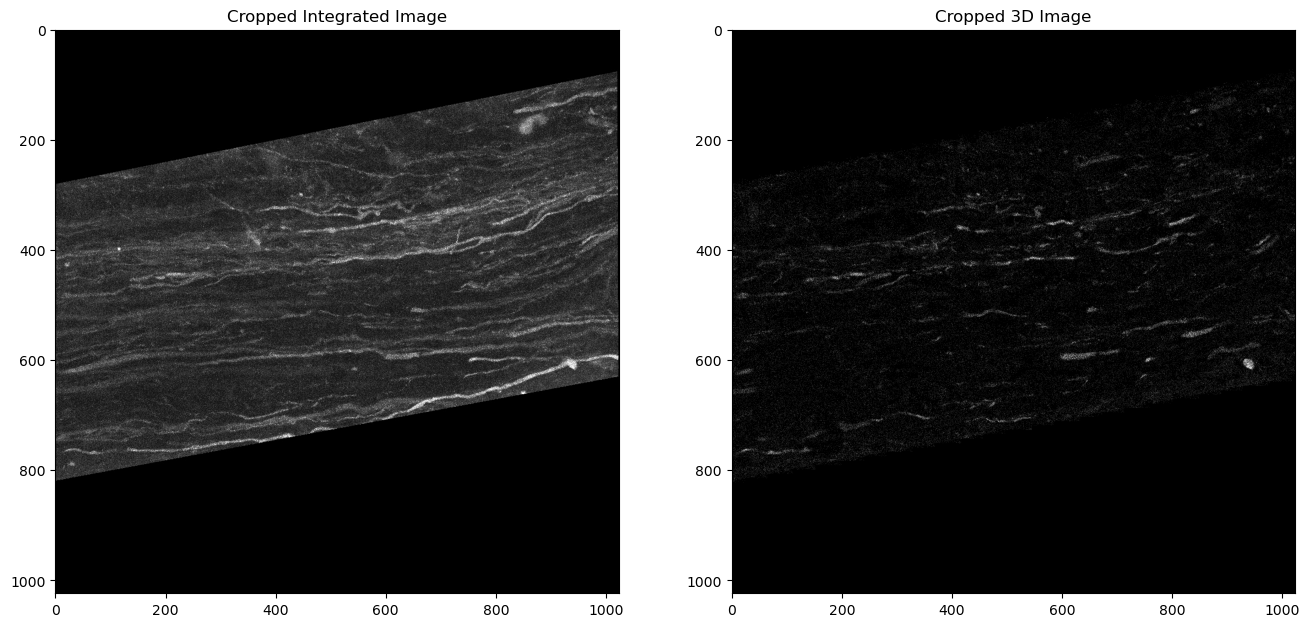

In [22]:
from matplotlib import pyplot as plt
import numpy as np
from QuestionMaster import Questions
import file_utilities as fu
from image_processor import process_image
from image_cropper import process_cropped, mask_3D_image


# Process the image and get integrated_image and image_3D
integrated_image, image_3D = process_image()

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(integrated_image, cmap='gray')
plt.title('Integrated Image')

plt.subplot(1, 2, 2)
plt.imshow(image_3D[0], cmap='gray')
plt.title('3D Image')

plt.show()

# Ask for cropping input
question = Questions("Do you want to crop the image?")
user_input = question.ask_question(input_type='yes_no')


# Assuming you have your integrated_image and image_3D already generated
# Example usage of process_cropped and mask_3D_image


# Crop and display
# press 's' for confirming the crop, press 'r' for restart selecting the shape of the crop.
if user_input:
    # Process cropped image
    cropped_image = process_cropped(integrated_image)
    # Mask the 3D image
    masked_3D_image = mask_3D_image(image_3D, cropped_image)
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(cropped_image, cmap='gray')
    plt.title('Cropped Integrated Image')

    plt.subplot(1, 2, 2)
    plt.imshow(masked_3D_image[0], cmap='gray')
    plt.title('Cropped 3D Image')

    plt.show()

else:
    print("The image does not crop.")
    masked_3D_image = image_3D.copy()

In [5]:
import numpy as np
import tifffile

# Save the 3D data as a TIFF file
tifffile.imwrite(fu.save_in_same_directory(file_path, 'cropped_original_image.tiff'), masked_3D_image)

NameError: name 'file_path' is not defined

## BM3D

In [24]:
import numpy as np
import bm4d
import cc3d
import napari
from skimage import measure
from bm3d import bm3d
import cv2 as cv
import matplotlib.pyplot as plt


from tqdm import tqdm

# Step 2: Apply BM3D denoising to each slice
denoised_images = []
noise_std_devs = []

for i in tqdm(range(masked_3D_image.shape[0]), desc="Denoising Images", unit="slice"):
    slice_2D = np.copy(masked_3D_image[i, :, :])
    # Filter out the 0 intensity values
    non_zero_values = slice_2D[slice_2D != 0]
    noise_std_dev = np.std(non_zero_values)
    denoised_image = bm3d(masked_3D_image[i, :, :], sigma_psd=noise_std_dev)
    noise_std_devs.append(noise_std_dev)
    denoised_images.append(denoised_image)
    
denoised_images = np.array(denoised_images)
#This ensures that all values below 0 are set to 0 and the value above 255 would be 255, while all other values remain unchanged.

denoised_images = np.clip(denoised_images, 0, 255)

noise_std_devs = np.array(noise_std_devs)

Denoising Images: 100%|██████████| 53/53 [05:20<00:00,  6.04s/slice]


In [25]:
#Simetime it doesn't shows the image in jupyter lab. Use jupyter notebook instead.
# Create a Napari viewer
viewer = napari.Viewer()

# Add the original merged image
viewer.add_image(masked_3D_image, name='Original Image')

# Add the BM3D denoised image to the Napari viewer
viewer.add_image(denoised_images, name='BM3D Image')

import stackview
print("Your image now")
stackview.curtain(masked_3D_image, denoised_images, continuous_update=True,zoom_factor =0.5)

Your image now


In [ ]:
import numpy as np
import tifffile

# Save the 3D data as a TIFF file
tifffile.imwrite(fu.save_in_same_directory(file_path, 'BM3D.tiff'), denoised_images)

## BM4D

In [32]:
from BM4DProcessor import BM4DProcessor
from QuestionMaster import Questions

question = Questions("Do you want to do BM4D? (If your image has intensive axon, recommend not. If you are not sure, try with BM4D first.)")
user_input = question.ask_question(input_type='yes_no')
if user_input:
    # Create instance of BM4DProcessor
    processor = BM4DProcessor(denoised_images)

    # Get user input for sigma for BM4D
    processor.get_user_PSD()

    # Perform BM4D and run viewer
    denoised_image = processor.do_bm4d()
    denoised_image = np.clip(denoised_image, 0, 255)


    # Label components on BM4D denoised image and label in napari
    if viewer:
        viewer.add_image(denoised_image, name='BM4D Image')

#    else:
#        viewer = napari.Viewer()
#        processor.run_viewer(denoised_image, viewer)

else:
    denoised_image = None


Do you want to do BM4D? (If your image has intensive axon, recommend not. If you are not sure, try with BM4D first.) (y/n):  n


In [ ]:
import numpy as np
import tifffile

# Save the 3D data as a TIFF file
tifffile.imwrite(fu.save_in_same_directory(file_path, 'BM4D.tiff'), denoised_image)

# remove background

In [34]:
from skimage.io import imread
import pyclesperanto_prototype as cle  # version 0.24.2
import napari
import napari_simpleitk_image_processing as nsitk  # version 0.4.5

# top hat sphere
if denoised_image is None:
    user_input = input("Do you want to do Bilateral denoise method? [y/n]: ")
    if user_input.lower() == 'y':
        use_default_threshold = input(f"Do you want to use the default denoise value? The default is 1 [y/n]: ")

        if use_default_threshold.lower() == 'y':
            # Use default value for threshold
            denoise_value= 1.0
        else:
            # Get user input for threshold
            denoise_value = float(input("Enter the denoise value: "))
            
        # bilateral filter

        bilateral_denoised_image = nsitk.bilateral_filter(denoised_images, denoise_value)
        viewer.add_image(bilateral_denoised_image, name='Result of Bilateral (n-SimpleITK)')
        bg_remove = cle.top_hat_box( bilateral_denoised_image, None, 10.0, 10.0, 0.0) # use napari assistant remove background
        viewer.add_image(bg_remove, name='bg_remove by top_hat_box (Bilateral)')
    else:
        bg_remove = cle.top_hat_box(denoised_images, None, 10.0, 10.0, 0.0) # use napari assistant remove background
        viewer.add_image(bg_remove, name='bg_remove by top_hat_box (BM3D)')
else:
    bg_remove = cle.top_hat_box( denoised_image, None, 10.0, 10.0, 0.0) # use napari assistant remove background
    viewer.add_image(bg_remove, name='bg_remove by top_hat_box (BM4D)')



Do you want to do Bilateral denoise method? [y/n]:  y
Do you want to use the default denoise value? The default is 1 [y/n]:  y


In [19]:
import numpy as np
import tifffile
tifffile.imwrite(fu.save_in_same_directory(file_path, 'bilateral_denoised_image.tiff'), bilateral_denoised_image)


# General threshold
see the cumulative distribution plots

In [14]:
import file_utilities as fu
import tifffile
import numpy as np

file_path = fu.choose_file()

masked_3D_image = tifffile.imread(file_path)

Selected File: C:/Users/Ding-Yang/Desktop/internship/Try don't merge/better images/Unet/Preprocess image/20220815 necroptosis Paula_PS-A2-60 series 53/bg_remove.tiff


Bin 1: Range 0.00 to 24.17, Count: 24983699.0
Bin 2: Range 24.17 to 48.35, Count: 104297.0
Bin 3: Range 48.35 to 72.52, Count: 15980.0
Bin 4: Range 72.52 to 96.70, Count: 5094.0
Bin 5: Range 96.70 to 120.87, Count: 2302.0
Bin 6: Range 120.87 to 145.05, Count: 1120.0
Bin 7: Range 145.05 to 169.22, Count: 697.0
Bin 8: Range 169.22 to 193.40, Count: 477.0
Bin 9: Range 193.40 to 217.57, Count: 393.0
Bin 10: Range 217.57 to 241.75, Count: 406.0


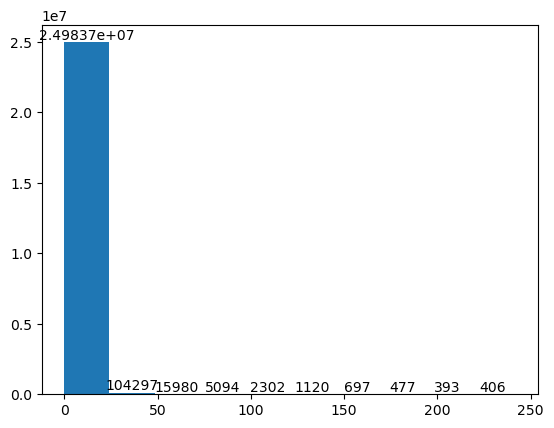

In [16]:
import matplotlib.pyplot as plt

# Assuming denoised_image is your image data
flat_data = np.array(masked_3D_image).flatten()

counts, edges, bars = plt.hist(flat_data[flat_data != 0])
plt.bar_label(bars, label_type='edge')

# Display information about each bin
for i in range(len(counts)):
    print(f"Bin {i + 1}: Range {edges[i]:.2f} to {edges[i + 1]:.2f}, Count: {counts[i]}")


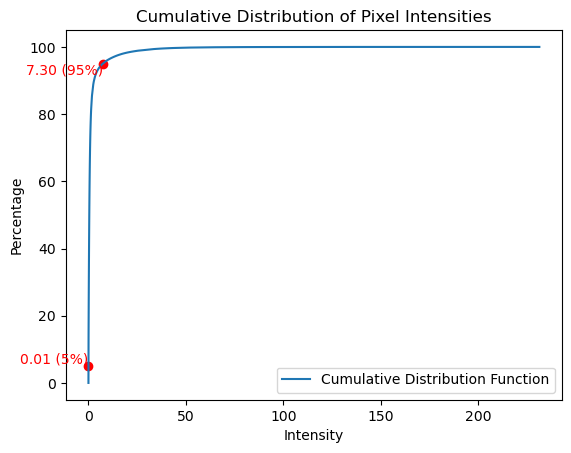

In [15]:
non_zero_pixels = flat_data[flat_data != 0]
# Calculate the cumulative distribution function (CDF)
sorted_pixels = np.sort(non_zero_pixels)
cumulative_percentage = np.arange(1, len(sorted_pixels) + 1) / len(sorted_pixels) * 100

# Plot the CDF
plt.plot(sorted_pixels, cumulative_percentage, label='Cumulative Distribution Function')

# Calculate intensity values for 5% and 95%
intensity_005 = np.percentile(sorted_pixels, 5)
intensity_095 = np.percentile(sorted_pixels, 95)

# Label points on the plot
plt.scatter([intensity_005, intensity_095], [5, 95], color='red')
plt.text(intensity_005, 5, f'{intensity_005:.2f} (5%)', verticalalignment='bottom', horizontalalignment='right', color='red')
plt.text(intensity_095, 95, f'{intensity_095:.2f} (95%)', verticalalignment='top', horizontalalignment='right', color='red')

# Add labels and title
plt.xlabel('Intensity')
plt.ylabel('Percentage')
plt.title('Cumulative Distribution of Pixel Intensities')
plt.legend()
plt.savefig(fu.save_in_same_directory(file_path,'rm_Cumulative_Distribution_plot.png'), bbox_inches='tight')  # Save the plot as PNG image
plt.show()

# Select sigma if you have a low axon density image

In [1]:
import file_utilities as fu
import tifffile
import numpy as np

file_path = fu.choose_file()


bg_remove = tifffile.imread(file_path)

Selected File: C:/Users/Ding-Yang/Desktop/internship/Try don't merge/better images/Unet/Preprocess image/section 2 740 TexRed Dextrans 3K dil 2 30 min CertnL 11.05.23/rm_bg - Copy.tiff


In [30]:
#Simetime it doesn't shows the image in jupyter lab. Use jupyter notebook instead.
from skimage.io import imread
import pyclesperanto_prototype as cle  # version 0.24.2
import napari_simpleitk_image_processing as nsitk  # version 0.4.5
import napari
from skimage.filters import gaussian, threshold_otsu, sobel
from skimage.measure import label
import stackview

def my_custom_code(image, sigma:float = 1, show_labels: bool = True):
    sigma =sigma
    binary_image =  cle.greater_or_equal_constant(image, None, sigma)
    edge_image = sobel(binary_image)
    
    if show_labels:
        return label(binary_image)
    else:
        return edge_image * 255 + image 

stackview.interact(my_custom_code, bg_remove, sigma=(0.0, 40, 0.5),zoom_factor =0.5)

In [61]:
print(f"Image shape: {bg_remove.shape}")


Image shape: (39, 1024, 1024)


# high axon density Segmentation and label

In [74]:
import file_utilities as fu
import tifffile
from matplotlib import pyplot as plt
import numpy as np
from QuestionMaster import Questions
from tqdm import tqdm

file_path = fu.choose_file()

# Open the TIFF image
bg_remove = tifffile.imread(file_path)

Selected File: C:/Users/Ding-Yang/Desktop/Thesis code/Optimization image/images/Ding Certnl-YFP 20x Pos2 Res acc3 LP 8.5 Z3  Step0.5/bg_remove.tiff


In [36]:
import scipy.ndimage
from patchify import patchify, unpatchify
import scipy.ndimage as ndi  # Assign alias

question = Questions("Do you want to cut your image into small patches? (If your image has intensive axon, recommend yes.)")
user_input = question.ask_question(input_type='yes_no')
if user_input:
    valid_patch_size = False  # Flag to control the loop
    
    # Loop until the user provides a valid patch size
    while not valid_patch_size:
        question = Questions("What size do you want to cut the image into small patches?")
        answer = question.ask_question(input_type='int')
        
        # Check if the size is divisible
        if bg_remove.shape[1] % answer == 0:
            bg_remove = np.array(bg_remove)
            img_patches = patchify(bg_remove, (bg_remove.shape[0], answer, answer), step=answer)  # Step=64 for 64 patches means no overlap
            image_dataset = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
            print(f"You get {image_dataset.shape[0]} patches with image size {image_dataset.shape[1:4]}")  # n_patches, x, y, z
            valid_patch_size = True  # Exit the loop if a valid size is found
        else:
            print(f"Your size could not divide {bg_remove.shape[1]}. Please enter a valid size.")

        
    def laplacian_sharpening_3d(image):
        laplacian = ndi.laplace(image)
        sharpened = image - laplacian
        return np.clip(sharpened, 0, 255)
    
    # Assuming `image_dataset` is already defined and is a 4D numpy array with shape (num_images, depth, height, width)
    num_images, depth, height, width = image_dataset.shape
    sharpened_img_dataset = np.zeros_like(image_dataset, dtype=np.uint8)
    mask_dataset = np.zeros_like(image_dataset, dtype=np.uint8)
    
    # Apply laplacian sharpening to each 3D image and store the results
    for i in range(num_images):
        image_3d = image_dataset[i]
        sharpened_image = laplacian_sharpening_3d(image_3d)
        sharpened_img_dataset[i] = sharpened_image
        mask = nsitk.scalar_image_k_means_clustering(sharpened_image)
        mask_dataset[i] = mask.astype(np.uint8)  # Ensure `mask_dataset` is integer type
        
else:
    image_dataset = np.array(bg_remove)
    # Add a new axis at the beginning to change the shape to (1, 17, 1024, 1024)
    user_input = float(input("Insert your final sigma(Use the previous as reference): "))
    
    binary_volume = cle.greater_or_equal_constant(image_dataset, None, user_input)# use napari assistant banizar
    markers, num_features = scipy.ndimage.label(binary_volume)
    # 过滤标签，只保留大小大于1000的标签
    min_label_size = 1000
    filtered_markers = np.zeros_like(markers)
    unique_labels, label_counts = np.unique(markers, return_counts=True)
    for label, count in zip(unique_labels, label_counts):
        if count >= min_label_size:
            filtered_markers[markers == label] = label
    mask_dataset= np.expand_dims(filtered_markers, axis=0)
    image_dataset = np.expand_dims(image_dataset, axis=0)
    sharpened_img_dataset = image_dataset

    print(f"You get 1 patch with image size {image_dataset.shape}")  # This will print (1, 17, 1024, 1024)

Do you want to cut your image into small patches? (If your image has intensive axon, recommend yes.) (y/n):  n
Insert your final sigma(Use the previous as reference):  7


You get 1 patch with image size (1, 53, 1024, 1024)


In [38]:
from napari_editor import ImageEditor
editor = ImageEditor(image_dataset, sharpened_img_dataset, mask_dataset)
editor.start()

Enter the image index to start with (0 to 0):  0


# Read the file and keep making GT image

In [86]:
import os
import tifffile as tiff
import numpy as np
from tkinter import filedialog, Tk

def load_or_check_datasets(directory_path):
    file_names = ['image_dataset.tiff', 'sharpened_img_dataset.tiff', 'mask_dataset.tiff']
    datasets = {}
    missing_files = []

    for file_name in file_names:
        file_path = os.path.join(directory_path, file_name)
        if os.path.exists(file_path):
            datasets[file_name] = tiff.imread(file_path)
            print(f"Loaded {file_name} from {file_path}")
        else:
            missing_files.append(file_name)
            print(f"{file_name} not found in {directory_path}")

    if missing_files:
        print(f"The following files are missing: {', '.join(missing_files)}")
        return datasets, missing_files
    else:
        print("All required files are loaded.")
        return datasets, None

def choose_directory_and_load_datasets():
    root = Tk()
    root.attributes("-topmost", True)
    root.withdraw()
    directory_path = filedialog.askdirectory(
        title="Select a directory to check or load datasets"
    )
    root.destroy()

    if not directory_path:
        print("No directory selected.")
        return None

    datasets, missing_files = load_or_check_datasets(directory_path)
    if missing_files:
        print("Some files are missing.")
    else:
        print("All files loaded successfully.")
    
    return datasets, missing_files

# Usage example:
datasets, missing_files = choose_directory_and_load_datasets()
if datasets:
    if 'image_dataset.tiff' in datasets:
        image_dataset = datasets['image_dataset.tiff']
    if 'sharpened_img_dataset.tiff' in datasets:
        sharpened_img_dataset = datasets['sharpened_img_dataset.tiff']
    if 'mask_dataset.tiff' in datasets:
        mask_dataset = datasets['mask_dataset.tiff']
    
    # Now you can proceed with your ImageEditor or other operations.


Loaded image_dataset.tiff from C:/Users/Ding-Yang/Desktop/Thesis code/try\image_dataset.tiff
Loaded sharpened_img_dataset.tiff from C:/Users/Ding-Yang/Desktop/Thesis code/try\sharpened_img_dataset.tiff
Loaded mask_dataset.tiff from C:/Users/Ding-Yang/Desktop/Thesis code/try\mask_dataset.tiff
All required files are loaded.
All files loaded successfully.


In [ ]:
from napari_editor import ImageEditor
editor = ImageEditor(image_dataset, sharpened_img_dataset, mask_dataset)
editor.start()

# After finishing the GT generation, reshape them into original shape for next step

In [40]:
from patchify import unpatchify

import os
import tifffile as tiff
import numpy as np
from tkinter import filedialog, Tk

def load_or_check_datasets(directory_path):
    file_names = ['image_dataset.tiff', 'sharpened_img_dataset.tiff', 'mask_dataset.tiff']
    datasets = {}
    missing_files = []

    for file_name in file_names:
        file_path = os.path.join(directory_path, file_name)
        if os.path.exists(file_path):
            datasets[file_name] = tiff.imread(file_path)
            print(f"Loaded {file_name} from {file_path}")
        else:
            missing_files.append(file_name)
            print(f"{file_name} not found in {directory_path}")

    if missing_files:
        print(f"The following files are missing: {', '.join(missing_files)}")
        return datasets, missing_files
    else:
        print("All required files are loaded.")
        return datasets, None

def choose_directory_and_load_datasets():
    root = Tk()
    root.attributes("-topmost", True)
    root.withdraw()
    directory_path = filedialog.askdirectory(
        title="Select a directory to check or load datasets"
    )
    root.destroy()

    if not directory_path:
        print("No directory selected.")
        return None

    datasets, missing_files = load_or_check_datasets(directory_path)
    if missing_files:
        print("Some files are missing.")
    else:
        print("All files loaded successfully.")
    
    return datasets, missing_files

# Usage example:
datasets, missing_files = choose_directory_and_load_datasets()
if datasets:
    if 'image_dataset.tiff' in datasets:
        image_dataset = datasets['image_dataset.tiff']
    if 'sharpened_img_dataset.tiff' in datasets:
        sharpened_img_dataset = datasets['sharpened_img_dataset.tiff']
    if 'mask_dataset.tiff' in datasets:
        mask_dataset = datasets['mask_dataset.tiff']
    
    # Now you can proceed with your ImageEditor or other operations.
import numpy as np
print(f"Your image shape now is {image_dataset.shape}")  # n_patches, x, y, z

from patchify import unpatchify
import numpy as np

# Assuming mask_dataset, image_dataset, and sharpened_img_dataset are currently in the shape (16, 39, 256, 256)
# Step 1: Reshape each dataset
grid_size = int(mask_dataset.shape[0] ** 0.5)  # Convert the square root result to an integer

mask_patches_reshaped = np.reshape(mask_dataset, (1, grid_size, grid_size, mask_dataset.shape[1], mask_dataset.shape[2], mask_dataset.shape[3]))
image_patches_reshaped = np.reshape(image_dataset, (1, grid_size, grid_size, image_dataset.shape[1], image_dataset.shape[2], image_dataset.shape[3]))
sharpened_patches_reshaped = np.reshape(sharpened_img_dataset, (1, grid_size, grid_size, sharpened_img_dataset.shape[1], sharpened_img_dataset.shape[2], sharpened_img_dataset.shape[3]))

# Step 2: Define the original shape
original_shape = (image_dataset.shape[1], 1024, 1024)  # where image_dataset.shape[1] is 39

# Step 3: Use unpatchify to reconstruct each dataset
reconstructed_mask = unpatchify(mask_patches_reshaped, original_shape)
reconstructed_image = unpatchify(image_patches_reshaped, original_shape)
reconstructed_sharpened = unpatchify(sharpened_patches_reshaped, original_shape)

print(f"Reconstructed mask shape: {reconstructed_mask.shape}")  # Should be (39, 1024, 1024)
print(f"Reconstructed image shape: {reconstructed_image.shape}")  # Should be (39, 1024, 1024)
print(f"Reconstructed sharpened image shape: {reconstructed_sharpened.shape}")  # Should be (39, 1024, 1024)


Loaded image_dataset.tiff from C:/Users/Ding-Yang/Desktop/Thesis code/try\image_dataset.tiff
Loaded sharpened_img_dataset.tiff from C:/Users/Ding-Yang/Desktop/Thesis code/try\sharpened_img_dataset.tiff
Loaded mask_dataset.tiff from C:/Users/Ding-Yang/Desktop/Thesis code/try\mask_dataset.tiff
All required files are loaded.
All files loaded successfully.
Your image shape now is (1, 53, 1024, 1024)
Reconstructed mask shape: (53, 1024, 1024)
Reconstructed image shape: (53, 1024, 1024)
Reconstructed sharpened image shape: (53, 1024, 1024)


In [42]:
import tifffile
from napari_editor import ImageEditor
# Call the static method directly
try:
    file_path = ImageEditor.choose_save_directory()
    print(f"Selected directory: {file_path}")
except Exception as e:
    print(e)

# Construct file paths for each dataset
mask_save_path = os.path.join(file_path, 'mask_dataset.tiff')
image_save_path = os.path.join(file_path, 'image_dataset.tiff')
sharpened_save_path = os.path.join(file_path, 'sharpened_img_dataset.tiff')

# Save the files using tifffile.imwrite
try:
    tifffile.imwrite(mask_save_path, reconstructed_mask)
    print(f"Saved reconstructed_mask at {mask_save_path}")

    tifffile.imwrite(image_save_path, reconstructed_image)
    print(f"Saved reconstructed_image at {image_save_path}")

    tifffile.imwrite(sharpened_save_path, reconstructed_sharpened)
    print(f"Saved reconstructed_sharpened at {sharpened_save_path}")

except Exception as e:
    print(f"Error saving files: {e}")

Selected directory: C:/Users/Ding-Yang/Desktop/Thesis code/try
Saved reconstructed_mask at C:/Users/Ding-Yang/Desktop/Thesis code/try\mask_dataset.tiff
Saved reconstructed_image at C:/Users/Ding-Yang/Desktop/Thesis code/try\image_dataset.tiff
Saved reconstructed_sharpened at C:/Users/Ding-Yang/Desktop/Thesis code/try\sharpened_img_dataset.tiff
